In [96]:
import csv
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [18]:
data_path = os.path.join("datasets_full/RPE1wt_CEP63+CETN2+PCNT_1/projections_channel/CEP63/tif/")
im = cv2.imread(data_path + "RPE1wt_CEP63+CETN2+PCNT_1_000_000_max_C1.tif")
data = pd.read_csv("datasets_full/annotations.csv")
print(np.unique(data['image_name']))

['RPE1wt_CEP152+GTU88+PCNT_1_000_000_max_C1'
 'RPE1wt_CEP152+GTU88+PCNT_1_000_000_max_C2'
 'RPE1wt_CEP152+GTU88+PCNT_1_000_000_max_C3'
 'RPE1wt_CEP152+GTU88+PCNT_1_000_001_max_C1'
 'RPE1wt_CEP152+GTU88+PCNT_1_000_001_max_C2'
 'RPE1wt_CEP152+GTU88+PCNT_1_000_001_max_C3'
 'RPE1wt_CEP152+GTU88+PCNT_1_000_002_max_C1'
 'RPE1wt_CEP152+GTU88+PCNT_1_000_002_max_C2'
 'RPE1wt_CEP152+GTU88+PCNT_1_000_002_max_C3'
 'RPE1wt_CEP152+GTU88+PCNT_1_000_003_max_C1'
 'RPE1wt_CEP152+GTU88+PCNT_1_000_003_max_C2'
 'RPE1wt_CEP152+GTU88+PCNT_1_000_003_max_C3'
 'RPE1wt_CEP152+GTU88+PCNT_1_000_004_max_C1'
 'RPE1wt_CEP152+GTU88+PCNT_1_000_004_max_C2'
 'RPE1wt_CEP152+GTU88+PCNT_1_000_004_max_C3'
 'RPE1wt_CEP152+GTU88+PCNT_1_001_000_max_C1'
 'RPE1wt_CEP152+GTU88+PCNT_1_001_000_max_C2'
 'RPE1wt_CEP152+GTU88+PCNT_1_001_000_max_C3'
 'RPE1wt_CEP152+GTU88+PCNT_1_001_001_max_C1'
 'RPE1wt_CEP152+GTU88+PCNT_1_001_001_max_C2'
 'RPE1wt_CEP152+GTU88+PCNT_1_001_001_max_C3'
 'RPE1wt_CEP152+GTU88+PCNT_1_001_002_max_C1'
 'RPE1wt_C

In [19]:
image_data = data[data['image_name'] == 'RPE1wt_CEP63+CETN2+PCNT_1_000_000_max_C1']
image_data_x = pd.DataFrame(data=image_data['x'])
image_data_y = pd.DataFrame(data=image_data['y'])
x = np.array(image_data_x['x'].values)
y = np.array(image_data_y['y'].values)
centriol_coords = np.stack((x, y), axis=1)
centriol_coords_mask = np.ones(centriol_coords.shape[0], dtype=np.bool)

In [20]:
print(centriol_coords.shape)

(54, 2)


In [21]:
point = centriol_coords[37]
point2= centriol_coords[38]

In [22]:
def generate_heatmaps(joints, joints_mask, image_size=(256,256), heatmap_size=(64,64), sigma=1):
    '''
    :param joints:  [num_joints, 3]
    :param joints_mask: [num_joints]
    :return: heatmaps [num_joints x heatmap_height x heatmap_width], joints_mask(1: visible, 0: invisible)
    '''

    num_joints = joints.shape[0]
    heatmaps = np.zeros((num_joints, heatmap_size[1], heatmap_size[0]), dtype=np.float32)
    mask = joints_mask.copy()
    tmp_size = sigma * 3

    for joint_id, (joint, joint_mask) in enumerate(zip(joints, joints_mask)):

        if not joint_mask: # joint is invisible
            continue

        feat_stride = (image_size[1] / heatmap_size[1], image_size[0] / heatmap_size[0])
        mu_x = int(joint[0] / feat_stride[0] + 0.5)
        mu_y = int(joint[1] / feat_stride[1] + 0.5)
        # Check that any part of the gaussian is in-bounds
        ul = [int(mu_x - tmp_size), int(mu_y - tmp_size)] # up-left
        br = [int(mu_x + tmp_size + 1), int(mu_y + tmp_size + 1)] # bottom-right

        if ul[0] >= heatmap_size[0] or ul[1] >= heatmap_size[1] \
                or br[0] < 0 or br[1] < 0:
            # If not, just return the image as is
            mask[joint_id] = False
            continue

        # # Generate gaussian
        size = 2 * tmp_size + 1
        x = np.arange(0, size, 1, np.float32)
        y = x[:, np.newaxis]
        x0 = y0 = size // 2
        g = np.exp(- ((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))

        # Usable gaussian range
        g_x = max(0, -ul[0]), min(br[0], heatmap_size[0]) - ul[0]
        g_y = max(0, -ul[1]), min(br[1], heatmap_size[1]) - ul[1]
        # Image range
        img_x = max(0, ul[0]), min(br[0], heatmap_size[0])
        img_y = max(0, ul[1]), min(br[1], heatmap_size[1])

        heatmaps[joint_id][img_y[0]:img_y[1], img_x[0]:img_x[1]] = \
            g[g_y[0]:g_y[1], g_x[0]:g_x[1]]

    return heatmaps, mask

In [23]:
heatmaps, _ = generate_heatmaps(centriol_coords, centriol_coords_mask, image_size=(2048, 2048), heatmap_size=(2048, 2048), sigma=1)

(54, 2048, 2048)
(2048, 2048, 3)


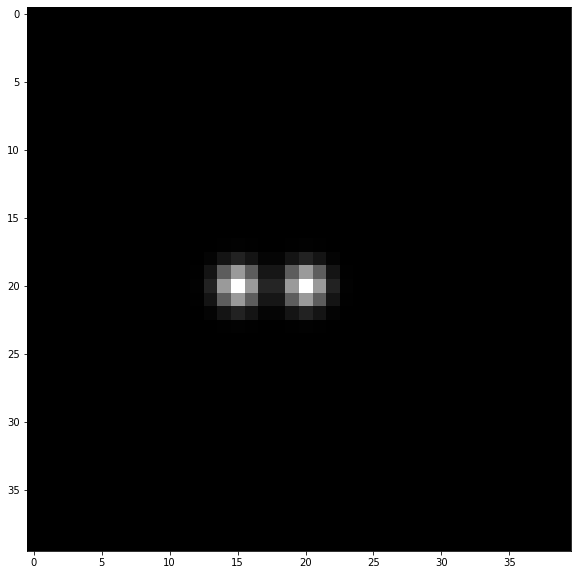

In [24]:
print(heatmaps.shape)
mask = np.sum(heatmaps, axis=0)
#new_mask = (mask - np.min(mask)) * 255 / np.max(mask)
new_mask = mask.copy()
#new_mask[new_mask > 0] = 255
new_mask = np.repeat(new_mask[:, :, np.newaxis], 3, axis=-1)
print(new_mask.shape)
plt.figure(figsize=(10, 10))
plt.imshow(new_mask[point[1]-20:point[1]+20, point[0]-20:point[0]+20])

In [25]:
def load_images_and_coords_from_folder(folders, csv_file_path):
    images = []
    annotations = []
    annotations_mask = []
    annotation_file = pd.read_csv(csv_file_path)
    for folder in folders:
        for filename in os.listdir(folder):
            img = cv2.imread(os.path.join(folder,filename))
            annot = annotation_file[annotation_file['image_name'] == filename[:-4]]
            if img is not None:
                images.append(img)
            if annot is not None:
                image_data_x = pd.DataFrame(data=annot['x'])
                image_data_y = pd.DataFrame(data=annot['y'])
                x = np.array(image_data_x['x'].values)
                y = np.array(image_data_y['y'].values)
                centriol_coords = np.stack((x, y), axis=1)
                centriol_coords_mask = np.ones(centriol_coords.shape[0], dtype=np.bool)
                
                annotations.append(centriol_coords)
                annotations_mask.append(centriol_coords_mask)
    return images, annotations, annotations_mask

In [39]:
f_path = os.path.join("datasets_full/RPE1wt_CEP63+CETN2+PCNT_1/projections_channel")
folder_path1 = os.path.join(f_path, "CEP63/tif")
# folder_path2 = os.path.join(f_path, "CETN2/tif")
# folder_path3 = os.path.join(f_path, "PCNT/tif")
# folders = [folder_path1, folder_path2, folder_path3]
folders = [folder_path1]

csv_file_path = os.path.join("datasets_full/annotations.csv")

In [40]:
all_images, annotations, annotations_mask = load_images_and_coords_from_folder(folders, csv_file_path)

In [41]:
print(len(all_images), len(annotations), len(annotations_mask))

25 25 25


In [103]:
def get_data_names(markers, channels, csv_file_path):
    """
    Markers is list of strings of the form ("RPE1wt_CEP63+CETN2+PCNT")
    and channel is also list of string and can be : "C0", "C1", "C2", "C3"
    """
    data = pd.read_csv(csv_file_path)
    data_names = np.unique(data['image_name'])
    new_data_names = data_names.copy()
    reduce_data_names_list = []
    #data_names = np.array2string(data_names)
    for marker in markers:
        for channel in channels:
            for i in range(len(data_names)):
                new_data_names[i] = data_names[i][:-15] + data_names[i][-3:]
            reduce_data_names_list.append(data_names[new_data_names == os.path.join(marker + "_" + channel)])
    return reduce_data_names_list

#####################################################################################
#TODO choose data images according to those name from annotations.cvs################
#####################################################################################
markers = ["RPE1wt_CEP63+CETN2+PCNT_1"]
channels = ["C1", "C2", "C3"]
names = get_data_names(markers, channels, csv_file_path)

def generates_mask_img(names, csv_file_path):
    data = pd.read_csv(csv_file_path)
    names = np.stack((names[0], names[1], names[2]), axis=1)
    for name in names:
        heatmaps_list = []
        for name_channel in name:
            data_image = data[data['image_name'] == name_channel]
            x = np.array(data_image['x'].values)
            y = np.array(data_image['y'].values)
            centriol_coords = np.stack((x, y), axis=1)
            centriol_coords_mask = np.ones(centriol_coords.shape[0], dtype=np.bool)

            heatmaps, _ = generate_heatmaps(centriol_coords, centriol_coords_mask, image_size=(2048, 2048),
                                            heatmap_size=(2048, 2048), sigma=1)
            heatmaps_list.append(np.sum(heatmaps, axis=0))
        
        heatmap = heatmaps_list[0] + heatmaps_list[1] + heatmaps_list[2]
        heatmap[heatmap >  0] = 1
        heatmap[heatmap <= 0] = 0
        heatmap = np.tile(heatmap[:, :, np.newaxis], (1, 1, 3))
        print(name[0][:-3])
        plt.imsave("datasets_full/RPE1wt_CEP63+CETN2+PCNT_1/projections_channel/Mask/" + name[0][:-3] + "_mask.png", heatmap)
        
generates_mask_img(names, csv_file_path)

RPE1wt_CEP63+CETN2+PCNT_1_000_000_max
RPE1wt_CEP63+CETN2+PCNT_1_000_001_max
RPE1wt_CEP63+CETN2+PCNT_1_000_002_max
RPE1wt_CEP63+CETN2+PCNT_1_000_003_max
RPE1wt_CEP63+CETN2+PCNT_1_000_004_max
RPE1wt_CEP63+CETN2+PCNT_1_001_000_max
RPE1wt_CEP63+CETN2+PCNT_1_001_001_max
RPE1wt_CEP63+CETN2+PCNT_1_001_002_max
RPE1wt_CEP63+CETN2+PCNT_1_001_003_max
RPE1wt_CEP63+CETN2+PCNT_1_001_004_max
RPE1wt_CEP63+CETN2+PCNT_1_002_000_max
RPE1wt_CEP63+CETN2+PCNT_1_002_001_max
RPE1wt_CEP63+CETN2+PCNT_1_002_002_max
RPE1wt_CEP63+CETN2+PCNT_1_002_003_max
RPE1wt_CEP63+CETN2+PCNT_1_003_000_max
RPE1wt_CEP63+CETN2+PCNT_1_003_001_max
RPE1wt_CEP63+CETN2+PCNT_1_003_002_max
RPE1wt_CEP63+CETN2+PCNT_1_003_003_max
RPE1wt_CEP63+CETN2+PCNT_1_003_004_max
RPE1wt_CEP63+CETN2+PCNT_1_004_000_max
RPE1wt_CEP63+CETN2+PCNT_1_004_001_max
RPE1wt_CEP63+CETN2+PCNT_1_004_002_max
RPE1wt_CEP63+CETN2+PCNT_1_004_003_max
RPE1wt_CEP63+CETN2+PCNT_1_004_004_max


In [104]:
mask = cv2.imread("datasets_full/RPE1wt_CEP63+CETN2+PCNT_1/projections_channel/Mask/RPE1wt_CEP63+CETN2+PCNT_1_000_000_max_mask.png")

In [107]:
print(np.unique(mask))

[  0 255]
